In [1]:
#bs0

In [1]:
import torch
leishu=4
device0 = torch.device('cuda:4' if torch.cuda.is_available() else "cpu")#训练集gpu
device1 = torch.device('cuda:4' if torch.cuda.is_available() else "cpu")#测试集gpu

In [2]:
import numpy as np
import pandas as pd
data_train=pd.read_csv("../data/data_train2.csv")
data_val=pd.read_csv("../data/data_val2.csv")
# data_test1=pd.read_csv("../data/data_test1.csv")
# data_test2=pd.read_csv("../data/data_test2.csv")

In [3]:
from transformers import AutoTokenizer, AutoModel
# added_token=['##char##']
# tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese",additional_special_tokens=added_token)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def text2token(text,tokenizer,max_length=100):
    text2id = tokenizer(
        text, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt"
    )
    input_ids=text2id["input_ids"].tolist()
    attention_mask=text2id["attention_mask"].tolist()
    return input_ids,attention_mask

In [4]:
def data2token(data_,tokenizer):
    text=[i for i in data_['title'].values]
    input_ids,attention_mask=text2token(text,tokenizer)
    data_['input_ids']=input_ids
    data_['attention_mask']=attention_mask
    return data_

In [5]:
data_train=data2token(data_train,tokenizer)
data_val=data2token(data_val,tokenizer)

In [6]:
from torch.utils.data import Dataset
class SentimentDataset(Dataset):
    def __init__(self,df):
        self.dataset = df
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        text = self.dataset.loc[idx, "title"]
        label = self.dataset.loc[idx, "label"]
        input_ids = self.dataset.loc[idx, "input_ids"]
        attention_mask = self.dataset.loc[idx, "attention_mask"]
        sample = {"text": text, "label": label,"input_ids":input_ids,"attention_mask":attention_mask}
        # print(sample)
        return sample
    
#按batch_size分
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import torch

batch_size=16
train_loader = DataLoader(
    SentimentDataset(data_train), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)
test_loader = DataLoader(
    SentimentDataset(data_val), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

In [7]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F

class fn_cls(nn.Module):
    def __init__(self,device):
        super(fn_cls, self).__init__()
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        self.model.resize_token_embeddings(len(tokenizer))##############
        self.model.to(device)
#         self.dropout = nn.Dropout(0.5)
        self.l1 = nn.Linear(768, leishu)

    def forward(self, x, attention_mask=None):
        outputs = self.model(x, attention_mask=attention_mask)
#         print(outputs[0])torch.Size([8, 100, 768])
#         print(outputs[1])torch.Size([8, 768])
#         print(outputs[0][:,0,:])torch.Size([8, 768])
        x = outputs[1]
#         x = self.dropout(x)
        x = self.l1(x)
        return x
cls = fn_cls(device0)

from torch import optim
optimizer = optim.Adam(cls.parameters(), lr=1e-4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
softmax = nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()#weight=weight
### 我的类别数为12
# criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])).float() ,
#                                 size_average=True)


In [9]:
# 定义日志（data文件夹下，同级目录新建一个data文件夹）
import time
import datetime
import pytz
tz = pytz.timezone('Asia/Shanghai')
def write_log(w):
    file_name = '../data/' + datetime.date.today().strftime('%m%d') + "_{}.log".format("bert_base2")
    t0 = datetime.datetime.now(tz).strftime('%H:%M:%S')
    info = "{} : {}".format(t0, w)
    print(info)
    with open(file_name, 'a') as f:
        f.write(info + '\n')
# write_log('test')

In [10]:
from sklearn import metrics
import numpy as np
from tqdm import tqdm

def test(device_test):
    cls.to(device_test)
    cls.eval()

    epoch_loss=0
    total=0
    correct=0
    output_all=[]
    label_all=[]
    for batch_idx,batch in enumerate(test_loader):
        with torch.no_grad():
#             print(batch['label'])
            label=batch['label'].to(device_test)#batch size * 1
            label_all.append(label.view(-1,1))
            input_ids=torch.stack(batch['input_ids']).t().to(device_test)#batch size * 100
            attention_mask=torch.stack(batch['attention_mask']).t().to(device_test)#batch size * 100
            
            #计算输出
            output = cls(input_ids, attention_mask=attention_mask)#batch size * 1
            total+=len(output)
            
            #计算loss
            
#             print(output,label)
            loss = criterion(output, label)
            epoch_loss+=loss
            ave_loss=epoch_loss/total
            
            #四舍五入
            output=softmax(output)
            output=output.argmax(dim=1)
            output_all.append(output)
            
            #计算准确率
            add_correct=(output== label).sum().item()
            correct+=add_correct
            acc=correct/total
            
            if batch_idx%5==0:
                print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{}，ave_loss：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc,
                    ave_loss
                    ),end= "\r")
            
            
            
    #结束：
    write_log('正确分类的样本数：{}，样本总数：{}，准确率：{}，ave_loss：{}'.format(
                    correct, total,acc,
                    ave_loss))
    
#     can't convert cuda:5 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    output_all=torch.cat(output_all,0)
    label_all=torch.cat(label_all,0)
    
    output_all=np.array(output_all.cpu())
    label_all=np.array(label_all.cpu())
    acc_score=metrics.accuracy_score(label_all,output_all)
    print(metrics.classification_report(label_all,output_all))
    write_log("准确率:"+str(acc_score))
    
    return acc,epoch_loss.item()

# test(device1)

In [12]:
def train_one_epoch(min_test_epoch_loss,device_train,epoch_num):
    write_log("______________________________________________")
    write_log("______________________________________________")
    write_log("_______________train epoch"+str(epoch_num)+" start_______________")
    write_log("______________________________________________")
    write_log("______________________________________________")
    cls.to(device_train)
    cls.train()

    epoch_loss=0
    total=0
    correct=0
    output_all=[]
    label_all=[]
    for batch_idx,batch in enumerate(train_loader):
        label=batch['label'].to(device_train)#batch size * 1
        label_all.append(label.view(-1,1))
        input_ids=torch.stack(batch['input_ids']).t().to(device_train)#batch size * 100
        attention_mask=torch.stack(batch['attention_mask']).t().to(device_train)#batch size * 100

        #计算输出
        output = cls(input_ids, attention_mask=attention_mask)#batch size * 1

        #计算loss
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        with torch.no_grad():
            #四舍五入
            output=softmax(output)
            output=output.argmax(dim=1)
            output_all.append(output)
            total+=len(output)
            
            #epoch_loss
            epoch_loss+=loss
            ave_loss=epoch_loss/total
            
            #计算准确率
            add_correct=(output== label).sum().item()
            correct+=add_correct
            acc=correct/total
            
            if batch_idx%5==0:
                print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{}，ave_loss：{}'.format(
                    batch_idx, len(train_loader),100.*batch_idx/len(train_loader), 
                    correct, total,acc,
                    ave_loss
                    ),end= "\r")
            
            
            
    #结束：
    
#     can't convert cuda:5 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    with torch.no_grad():
        output_all=torch.cat(output_all,0)
        label_all=torch.cat(label_all,0)

        output_all=np.array(output_all.cpu())
        label_all=np.array(label_all.cpu())
        acc_score=metrics.accuracy_score(label_all,output_all)
        
#     print(metrics.classification_report(label_all,output_all))
    write_log('__________________train end__________________')
    write_log('正确分类的样本数：{}，样本总数：{}，准确率：{}，ave_loss：{}'.format(
                    correct, total,acc,
                    ave_loss))
    
    write_log("准确率:"+str(acc_score))
    
    write_log('__________________test start__________________')
    test_acc,test_epoch_loss=test(device1)
    if min_test_epoch_loss>test_epoch_loss:
        min_test_epoch_loss=test_epoch_loss
        write_log("store model")
        end = time.time()
        torch.save(cls,"../data/cls2_"+str(epoch_num)+'_'+str(round(test_acc,5))+'_'+str(round(test_epoch_loss,5))+".model")
    
    write_log('train_acc:'+str(acc)+'  train_epoch_loss:'+str(epoch_loss.item())+'  test_acc:'+str(test_acc)+'  test_epoch_loss:'+str(test_epoch_loss))
    write_log('__________________test end__________________')
    
    train_acc_l.append(acc)
    train_epoch_loss_l.append(epoch_loss.item())
    test_acc_l.append(test_acc)
    test_epoch_loss_l.append(test_epoch_loss)
    write_log("______________________________________________")
    write_log("______________________________________________")
    write_log("_______________train epoch "+str(epoch_num)+" end_______________")
    write_log("______________________________________________")
    write_log("______________________________________________")
    return min_test_epoch_loss
    

    
def train(epoch_num):
    min_test_epoch_loss=999999
    for i in range(epoch_num):
        min_test_epoch_loss=train_one_epoch(min_test_epoch_loss,device0,i)

    
# train_one_epoch(device0,0)
# train()

In [ ]:
cls = fn_cls(device0)

from torch import optim
optimizer = optim.Adam(cls.parameters(), lr=1e-6)
# test(device1)
train_acc_l=[]
train_epoch_loss_l=[]
test_acc_l=[]
test_epoch_loss_l=[]
train(10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


17:15:10 : ______________________________________________
17:15:10 : ______________________________________________
17:15:10 : _______________train epoch0 start_______________
17:15:10 : ______________________________________________
17:15:10 : ______________________________________________
17:23:19 : __________________train end__________________57108317214，ave_loss：0.04456441476941109
17:23:19 : 正确分类的样本数：49012，样本总数：66179，准确率：0.7405974704966832，ave_loss：0.04456552490592003
17:23:19 : 准确率:0.7405974704966832
17:23:19 : __________________test start__________________
17:23:52 : 正确分类的样本数：10917，样本总数：13238，准确率：0.8246714005136727，ave_loss：0.030980965122580528342262
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3316
           1       0.85      0.91      0.88      3247
           2       0.77      0.78      0.78      3350
           3       0.80      0.80      0.80      3325

    accuracy                           0.82     13238
   macro

18:07:04 : __________________train end__________________68713733076，ave_loss：0.021956223994493484
18:07:04 : 正确分类的样本数：57744，样本总数：66179，准确率：0.8725426494809532，ave_loss：0.021958429366350174
18:07:04 : 准确率:0.8725426494809532
18:07:04 : __________________test start__________________
18:07:37 : 正确分类的样本数：11362，样本总数：13238，准确率：0.8582867502643904，ave_loss：0.02465919405221939064926
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      3316
           1       0.89      0.93      0.91      3247
           2       0.80      0.83      0.81      3350
           3       0.83      0.85      0.84      3325

    accuracy                           0.86     13238
   macro avg       0.86      0.86      0.86     13238
weighted avg       0.86      0.86      0.86     13238

18:07:37 : 准确率:0.8582867502643904
18:07:37 : store model
18:07:37 : train_acc:0.8725426494809532  train_epoch_loss:1453.1868896484375  test_acc:0.8582867502643904  test_epoch_loss:326.438415

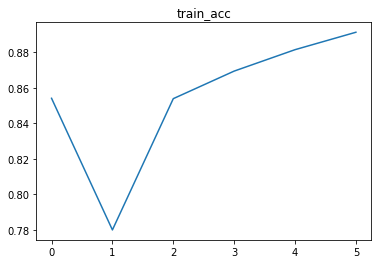

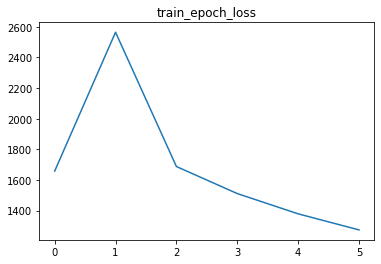

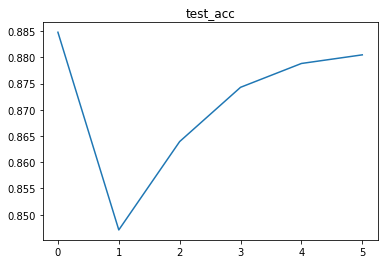

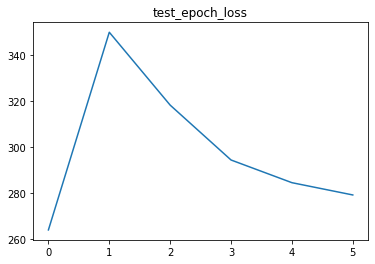

In [14]:
import matplotlib.pyplot as plt
def _plt():
    plt.plot([i for i in range(len(train_acc_l))], train_acc_l)
    plt.title('train_acc')
    plt.show()
    plt.plot([i for i in range(len(train_epoch_loss_l))], train_epoch_loss_l)
    plt.title('train_epoch_loss')
    plt.show()
    plt.plot([i for i in range(len(test_acc_l))], test_acc_l)
    plt.title('test_acc')
    plt.show()
    plt.plot([i for i in range(len(test_epoch_loss_l))], test_epoch_loss_l)
    plt.title('test_epoch_loss')
    plt.show()
_plt()

In [ ]:
import time
end = time.time()
torch.save(cls,"../data/cls_"+str(end)+".model")

In [ ]:
import torch
cls=torch.load("../data/cls.model",map_location=device0)

In [29]:
def predict(device,s_l,cls):
    with torch.no_grad():
        cls.to(device)
        cls.eval()
        text2id = tokenizer(
            s_l, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
        )
        input_ids=text2id["input_ids"].to(device)
        mask=text2id["attention_mask"].to(device)
        output = cls(input_ids, attention_mask=mask)

        output1=softmax(output)
        output2=output.argmax(dim=1)
        return output1,output2
    
    
    
    


In [30]:
s=['好好好','中中中','差差差']
print(predict(device1,s,cls))

(tensor([[0.9933, 0.0039, 0.0028],
        [0.0040, 0.9915, 0.0045],
        [0.0144, 0.0067, 0.9789]], device='cuda:7'), tensor([0, 1, 2], device='cuda:7'))


/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
